In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
# os.environ["CUDA_LAUNCH_BLOCKING"]='1' # for debugging on CUDA. Need to restart the kernel if you want to turn this on or off.
import numpy as np
import torch
from torch import Tensor, nn
import math
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import r2_score, mean_absolute_error
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import random
from pathlib import Path
from datetime import datetime
from sequence_models_utility import get_num_examples_in_data, load_and_preprocess_sequence_data, \
                                    train_model_with_params_batched, mse_loss_l1_coeff_reg, mse_loss_l2_coeff_reg, \
                                    get_y_pred, get_r_squared, get_mean_abs_err, get_count_invalid_preds
import itertools

## Parameters

In [3]:
data_file = os.path.join(os.getcwd(), "CAISO_Data_2019_2021_NN.csv")
work_dir = os.path.join(os.getcwd(), "attention_models")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Take a look at split of data amongst train/val/test sets depending on train/val/test-block-sizes and sequence length

In [13]:
feature_cols = feature_cols = ['Load', 'VRE', 'Hour', 'Day_of_Year']
days_in_train_block = 6
days_in_val_block = 2
days_in_test_block = 2
seq_len = 4
data_sets = load_and_preprocess_sequence_data(data_file, feature_cols, days_in_train_block, 
                                              days_in_val_block, days_in_test_block, seq_len, device)
print(f"After splitting data to blocks of example sequences...")
total_examples = sum(len(data[set_name]["X"]) for set_name in ["train", "val", "test"])
for set_name, data in data_sets.items():
    if set_name == "full":
        continue
    print(f"Number of example sequences in {set_name} set: {len(data['X'])} ({100*len(data['X'])/total_examples:.1f}%)")

After splitting data to blocks of example sequences...
Number of example sequences in train set: 15158 (60.5%)
Number of example sequences in val set: 4944 (19.7%)
Number of example sequences in test set: 4935 (19.7%)


In [14]:
data_sets["train"]["y"].shape

torch.Size([15158, 4])

In [15]:
data_sets["train"]["X"].shape

torch.Size([15158, 4, 4])

In [44]:
feature_cols = feature_cols = ['Load', 'VRE', 'Hour', 'Day_of_Year']
days_in_train_block = 6
days_in_val_block = 2
days_in_test_block = 2
seq_len = 4
data_sets = load_and_preprocess_sequence_data(data_file, feature_cols, days_in_train_block, 
                                              days_in_val_block, days_in_test_block, seq_len, device)
print(f"After splitting data to blocks of example sequences...")
total_examples = sum(len(data_sets[set_name]["X"]) for set_name in ["train", "val", "test"])
for set_name, data in data_sets.items():
    if set_name == "full":
        continue
    print(f"Number of example sequences in {set_name} set: {len(data['X'])} ({100*len(data['X'])/total_examples:.1f}%)")

After splitting data to blocks of example sequences...
Number of example sequences in train set: 15264 (60.2%)
Number of example sequences in val set: 5050 (19.9%)
Number of example sequences in test set: 5040 (19.9%)


In [45]:
data_sets["train"]["y"].shape

torch.Size([15264, 4])

In [46]:
data_sets["train"]["X"].shape

torch.Size([15264, 4, 4])

## define model

In [4]:
class TransformerModel(nn.Module):

    def __init__(self, input_size: int, output_size: int, d_model: int, nhead: int, dim_ff: int,
                 nlayers: int, dropout: float = 0.5, ):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_ff, dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Linear(input_size, d_model)
        self.d_model = d_model
        # for decoder, 2 options may be worth trying:
        # 1. just using last sequence term and passing through linear layer in which case linear is d_model x output
        # 2. concatenating sequence terms and then going through linear - linear would be seq_len*d_model x output
        # let's try 1 first.
        self.decoder = nn.Linear(d_model, output_size)

        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: Tensor, src_mask: Tensor = None) -> Tensor:
        """
        Args:
            src: Tensor, shape [batch_size, seq_len, features]
            src_mask: Tensor, shape [seq_len, seq_len]

        Returns:
            output Tensor of shape [seq_len, batch_size, ntoken]
        """
        # input is batch x seq x feature
        src = self.encoder(src) * math.sqrt(self.d_model)
        src = src.permute(1,0,2)  # flip batch and seq dims for pos_encoder method (make this better)
        src = self.pos_encoder(src)
        src = src.permute(1,0,2)  # flip back
        output = self.transformer_encoder(src, src_mask)
        # output at this point is batch x seq_len x d_model.
        # can either concat sequence items or take just the last one.
        output = torch.unsqueeze(output[:,-1,:], 1) # take just last sequence item
        output = self.decoder(output)
        return output
    

class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)


def generate_square_subsequent_mask(sz: int) -> Tensor:
    """Generates an upper-triangular matrix of -inf, with zeros on diag."""
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)


## Model Training / Hyperparam Tuning

In [6]:
# may want to switch to cpu explicitly if having issues with debugging
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [28]:
model = TransformerModel(input_size=4, output_size=3, d_model=64, nhead=4, dim_ff=64, nlayers=2)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

50947


In [13]:
# data settings
feature_cols = ['Load', 'VRE', 'Hour', 'Day_of_Year']
days_in_train_block = 6
days_in_val_block = 2
days_in_test_block = 2
seq_len_list = [24, 12, 8, 4]

# model settings
input_size = len(feature_cols)
output_size = 3  # 2 for no intercept term, 3 to include an intercept term
d_model_list = [64, 128] # 16, 64 # dim of Q,K,V in transformer
nhead_list = [4, 8]  # number of attention heads
dim_ff_list = [64, 128]  # dim of feed forward layer in encoder blocks
nlayers_list = [2]  # number of encoder blocks
dropout_list = [.1, .2]
#####
# d_model_list = [128] # 16, 64 # dim of Q,K,V in transformer
# nhead_list = [8]  # number of attention heads
# dim_ff_list = [128]  # dim of feed forward layer in encoder blocks
# nlayers_list = [4]  # number of encoder blocks
# dropout_list = [.5]
#####
final_point_only = True  # Currently must be set to True as I have not implemented an option in our transformer model to predict values for each input hour

# optimizer settings
learning_rate = .001
weight_decay_list = [.01, .1]

# loss function settings
loss_function = mse_loss_l1_coeff_reg
MEF_reg_weight, MDF_reg_weight = 1e7, 1e7

# training settings
experiment_dir_prefix = f"grid_search4_seq,dmodel,nhead,dimff,nlayers,drop,wdecay"
####
# experiment_dir_prefix = f"test_grid_search_2"
####

experiment_dir = os.path.join(work_dir, experiment_dir_prefix)
batch_size = 2048
epochs = 1500
min_save_r2 = .87
max_save_mae = 140000
print_freq = 100

hyperparam_lists = [seq_len_list, d_model_list, nhead_list, dim_ff_list, nlayers_list, dropout_list, weight_decay_list]
results_df = pd.DataFrame(columns=["seq_len", "d_model", "nhead", "dim_ff", "nlayers", "dropout", "weight_decay", "r2", "mae"])
# if you have a run that was already started and you want to pick up where you left off, use below lines
# results_df = pd.read_csv(os.path.join(experiment_dir, "param_search_summary.csv")).iloc[:,1:]
# num_to_skip = len(results_df)
for i, hyperparams in enumerate(tqdm(list(itertools.product(*hyperparam_lists)))):
    [seq_len, d_model, nhead, dim_ff, nlayers, dropout, weight_decay] = hyperparams
    print(f"{seq_len=}, {d_model=}, {nhead=}, {dim_ff=}, {nlayers=}, {dropout=}, {weight_decay=}")
    
    if i < num_to_skip:
        continue
    
    hyperparam_str = ",".join(str(p) for p in hyperparams)
    model_dir = os.path.join(experiment_dir, hyperparam_str)
    
    model_settings = {"input_size": input_size,
                  "output_size": output_size,
                  "d_model": d_model,
                  "nhead": nhead,
                  "dim_ff": dim_ff,
                  "nlayers": nlayers,
                  "dropout": dropout,
                  "final_point_only": final_point_only
                 }
    
    data_settings = {"feature_cols": feature_cols,
                 "days_in_train_block": days_in_train_block,
                 "days_in_val_block": days_in_val_block,
                 "days_in_test_block": days_in_test_block,
                 "seq_len": seq_len}
    
    # Load and preprocess data
    data_sets = load_and_preprocess_sequence_data(data_file, feature_cols, days_in_train_block, 
                                              days_in_val_block, days_in_test_block, seq_len, device)

    
    model = TransformerModel(input_size, output_size, d_model, nhead, dim_ff, nlayers, dropout)
    model.to(device)
    
    # evaluate
    r2, mae = train_model_with_params_batched(data_sets, data_settings, # data
                            model, model_settings,  # model settings
                            learning_rate, weight_decay,  # optimizer settings
                            loss_function, MEF_reg_weight, MDF_reg_weight,  # loss function settings
                            model_dir, batch_size, epochs, print_freq, min_save_r2, max_save_mae, verbose=False)  # train settings
    r2_str = f"{r2:.4f}" if r2 else ""
    mae_str = f"{mae:.2f}" if mae else ""
    print(f"Best R2: {r2_str}, Best MAE: {mae_str}\n")
    # add to results summary
    result_row = hyperparams + (r2_str, mae_str)
    results_df.loc[len(results_df)] = result_row
    results_df.to_csv(os.path.join(experiment_dir, "param_search_summary.csv"))

  0%|          | 0/128 [00:00<?, ?it/s]

seq_len=24, d_model=64, nhead=4, dim_ff=64, nlayers=2, dropout=0.1, weight_decay=0.01
seq_len=24, d_model=64, nhead=4, dim_ff=64, nlayers=2, dropout=0.1, weight_decay=0.1
seq_len=24, d_model=64, nhead=4, dim_ff=64, nlayers=2, dropout=0.2, weight_decay=0.01
seq_len=24, d_model=64, nhead=4, dim_ff=64, nlayers=2, dropout=0.2, weight_decay=0.1
seq_len=24, d_model=64, nhead=4, dim_ff=128, nlayers=2, dropout=0.1, weight_decay=0.01
seq_len=24, d_model=64, nhead=4, dim_ff=128, nlayers=2, dropout=0.1, weight_decay=0.1
seq_len=24, d_model=64, nhead=4, dim_ff=128, nlayers=2, dropout=0.2, weight_decay=0.01
seq_len=24, d_model=64, nhead=4, dim_ff=128, nlayers=2, dropout=0.2, weight_decay=0.1
seq_len=24, d_model=64, nhead=8, dim_ff=64, nlayers=2, dropout=0.1, weight_decay=0.01
seq_len=24, d_model=64, nhead=8, dim_ff=64, nlayers=2, dropout=0.1, weight_decay=0.1
seq_len=24, d_model=64, nhead=8, dim_ff=64, nlayers=2, dropout=0.2, weight_decay=0.01
seq_len=24, d_model=64, nhead=8, dim_ff=64, nlayers=2, 

  0%|          | 0/1500 [00:00<?, ?it/s]

Best R2: 0.8734, Best MAE: 140348.38

seq_len=4, d_model=64, nhead=8, dim_ff=128, nlayers=2, dropout=0.1, weight_decay=0.1


  0%|          | 0/1500 [00:00<?, ?it/s]

Best R2: 0.8755, Best MAE: 139393.03

seq_len=4, d_model=64, nhead=8, dim_ff=128, nlayers=2, dropout=0.2, weight_decay=0.01


  0%|          | 0/1500 [00:00<?, ?it/s]

Best R2: 0.8765, Best MAE: 138669.47

seq_len=4, d_model=64, nhead=8, dim_ff=128, nlayers=2, dropout=0.2, weight_decay=0.1


  0%|          | 0/1500 [00:00<?, ?it/s]

Best R2: 0.8745, Best MAE: 139719.44

seq_len=4, d_model=128, nhead=4, dim_ff=64, nlayers=2, dropout=0.1, weight_decay=0.01


  0%|          | 0/1500 [00:00<?, ?it/s]

Best R2: 0.8775, Best MAE: 138661.86

seq_len=4, d_model=128, nhead=4, dim_ff=64, nlayers=2, dropout=0.1, weight_decay=0.1


  0%|          | 0/1500 [00:00<?, ?it/s]

Best R2: 0.8764, Best MAE: 139167.30

seq_len=4, d_model=128, nhead=4, dim_ff=64, nlayers=2, dropout=0.2, weight_decay=0.01


  0%|          | 0/1500 [00:00<?, ?it/s]

Best R2: 0.8746, Best MAE: 140071.89

seq_len=4, d_model=128, nhead=4, dim_ff=64, nlayers=2, dropout=0.2, weight_decay=0.1


  0%|          | 0/1500 [00:00<?, ?it/s]

Best R2: 0.8736, Best MAE: 140709.55

seq_len=4, d_model=128, nhead=4, dim_ff=128, nlayers=2, dropout=0.1, weight_decay=0.01


  0%|          | 0/1500 [00:00<?, ?it/s]

Best R2: 0.8766, Best MAE: 138979.34

seq_len=4, d_model=128, nhead=4, dim_ff=128, nlayers=2, dropout=0.1, weight_decay=0.1


  0%|          | 0/1500 [00:00<?, ?it/s]

Best R2: 0.8757, Best MAE: 139027.95

seq_len=4, d_model=128, nhead=4, dim_ff=128, nlayers=2, dropout=0.2, weight_decay=0.01


  0%|          | 0/1500 [00:00<?, ?it/s]

Best R2: 0.8760, Best MAE: 139894.98

seq_len=4, d_model=128, nhead=4, dim_ff=128, nlayers=2, dropout=0.2, weight_decay=0.1


  0%|          | 0/1500 [00:00<?, ?it/s]

Best R2: 0.8760, Best MAE: 139398.80

seq_len=4, d_model=128, nhead=8, dim_ff=64, nlayers=2, dropout=0.1, weight_decay=0.01


  0%|          | 0/1500 [00:00<?, ?it/s]

Best R2: 0.8764, Best MAE: 138957.12

seq_len=4, d_model=128, nhead=8, dim_ff=64, nlayers=2, dropout=0.1, weight_decay=0.1


  0%|          | 0/1500 [00:00<?, ?it/s]

Best R2: 0.8761, Best MAE: 139582.27

seq_len=4, d_model=128, nhead=8, dim_ff=64, nlayers=2, dropout=0.2, weight_decay=0.01


  0%|          | 0/1500 [00:00<?, ?it/s]

Best R2: 0.8729, Best MAE: 140809.70

seq_len=4, d_model=128, nhead=8, dim_ff=64, nlayers=2, dropout=0.2, weight_decay=0.1


  0%|          | 0/1500 [00:00<?, ?it/s]

Best R2: 0.8761, Best MAE: 139144.55

seq_len=4, d_model=128, nhead=8, dim_ff=128, nlayers=2, dropout=0.1, weight_decay=0.01


  0%|          | 0/1500 [00:00<?, ?it/s]

Best R2: 0.8756, Best MAE: 139413.39

seq_len=4, d_model=128, nhead=8, dim_ff=128, nlayers=2, dropout=0.1, weight_decay=0.1


  0%|          | 0/1500 [00:00<?, ?it/s]

Best R2: 0.8749, Best MAE: 139582.23

seq_len=4, d_model=128, nhead=8, dim_ff=128, nlayers=2, dropout=0.2, weight_decay=0.01


  0%|          | 0/1500 [00:00<?, ?it/s]

Best R2: 0.8768, Best MAE: 139146.41

seq_len=4, d_model=128, nhead=8, dim_ff=128, nlayers=2, dropout=0.2, weight_decay=0.1


  0%|          | 0/1500 [00:00<?, ?it/s]

Best R2: 0.8752, Best MAE: 140240.61



In [27]:
results_df.astype(float).sort_values("r2", ascending=False)[:50]

,seq_len,d_model,nhead,dim_ff,nlayers,dropout,weight_decay,r2,mae
32,12.0,64.0,4.0,64.0,2.0,0.1,0.01,0.8864,135584.67
42,12.0,64.0,8.0,64.0,2.0,0.2,0.01,0.8863,136223.31
52,12.0,128.0,4.0,128.0,2.0,0.1,0.01,0.8859,135867.23
37,12.0,64.0,4.0,128.0,2.0,0.1,0.10,0.8858,135749.55
45,12.0,64.0,8.0,128.0,2.0,0.1,0.10,0.8858,135762.27
63,12.0,128.0,8.0,128.0,2.0,0.2,0.10,0.8857,135466.50
54,12.0,128.0,4.0,128.0,2.0,0.2,0.01,0.8856,135356.00
59,12.0,128.0,8.0,64.0,2.0,0.2,0.10,0.8856,135950.06
48,12.0,128.0,4.0,64.0,2.0,0.1,0.01,0.8855,135922.78
35,12.0,64.0,4.0,64.0,2.0,0.2,0.10,0.8853,136473.06


Alternatively you can train a single model in the below cell

Model Settings:
	input_size=4
	output_size=3
	d_model=64
	nhead=4
	dim_ff=64
	nlayers=2
	dropout=0.1
	final_point_only=True
Model Architecture:
TransformerModel(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=64, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=64, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): Mu

  0%|          | 0/1500 [00:00<?, ?it/s]

[Epoch 0]
	Train Set: Loss=3.055e+11, R Squared=0.0085, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=2.981e+11, R Squared=0.0085, Invalid MEFs=0, Invalid MDFs=0
[Epoch 100]
	Train Set: Loss=1.192e+11, R Squared=0.6140, Invalid MEFs=0, Invalid MDFs=1
	Val Set: Loss=1.159e+11, R Squared=0.6146, Invalid MEFs=0, Invalid MDFs=0
[Epoch 200]
	Train Set: Loss=4.899e+10, R Squared=0.8410, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=4.685e+10, R Squared=0.8442, Invalid MEFs=0, Invalid MDFs=0
[Epoch 300]
	Train Set: Loss=4.284e+10, R Squared=0.8610, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=4.098e+10, R Squared=0.8637, Invalid MEFs=0, Invalid MDFs=0
[Epoch 400]
	Train Set: Loss=4.001e+10, R Squared=0.8702, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.912e+10, R Squared=0.8699, Invalid MEFs=0, Invalid MDFs=0
[Epoch 500]
	Train Set: Loss=4.011e+10, R Squared=0.8772, Invalid MEFs=0, Invalid MDFs=9
	Val Set: Loss=3.887e+10, R Squared=0.8735, Invalid MEFs=0, Invalid MDFs=3
[Epoch 600]
	Train

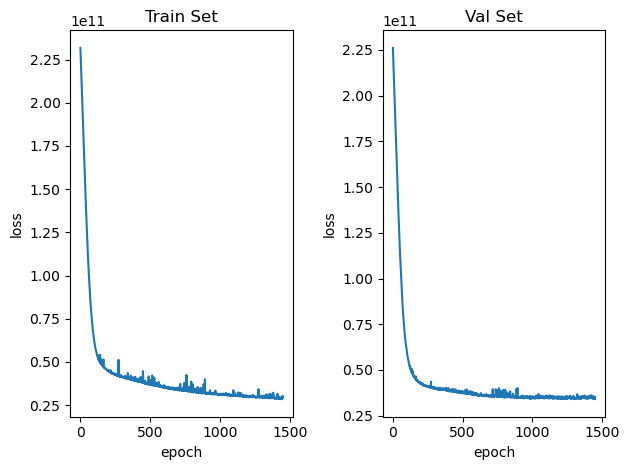

Best R Squared seen on epoch 1350: 0.8868
Best MAE seen on epoch 1349: 134897.14
Best-R2-model with 0 invalid coefficients predicted on train/val sets:
	Validation R2: 0.8861
	Validation MAE: 135515.58
	Epoch seen: 1483
	Model file: C:\Users\nicklein\Documents\MEF-Regression\attention_models\rerun_best_model\2023_01_26-05_30_39_PM\epoch=1483,r2=0.8861,mae=135515,Invalids=0.pth
Best-MAE-model with 0 invalid coefficients predicted on train/val sets:
	Validation R2: 0.8861
	Validation MAE: 135515.58
	Epoch seen: 1483
	Model file: C:\Users\nicklein\Documents\MEF-Regression\attention_models\rerun_best_model\2023_01_26-05_30_39_PM\epoch=1483,r2=0.8861,mae=135515,Invalids=0.pth


In [48]:
# data settings
feature_cols = ['Load', 'VRE', 'Hour', 'Day_of_Year']
days_in_train_block = 6
days_in_val_block = 2
days_in_test_block = 2
seq_len = 12

# model settings
input_size = len(feature_cols)
output_size = 3  # 2 for no intercept term, 3 to include an intercept term
d_model = 64
nhead = 4
dim_ff = 64
nlayers = 2
dropout = .1
final_point_only = True  # Currently must be set to True as I have not implemented an option in our transformer model to predict values for each input hour

# optimizer settings
learning_rate = .001
weight_decay = .01

# loss function settings
loss_function = mse_loss_l1_coeff_reg
MEF_reg_weight, MDF_reg_weight = 1e7, 1e7

# training settings
model_dir = os.path.join(work_dir, "rerun_best_model")
batch_size = 2048
epochs = 1500
min_save_r2 = .87
max_save_mae = 140000
print_freq = 100

model_settings = {"input_size": input_size,
              "output_size": output_size,
              "d_model": d_model,
              "nhead": nhead,
              "dim_ff": dim_ff,
              "nlayers": nlayers,
              "dropout": dropout,
              "final_point_only": final_point_only
             }

data_settings = {"feature_cols": feature_cols,
             "days_in_train_block": days_in_train_block,
             "days_in_val_block": days_in_val_block,
             "days_in_test_block": days_in_test_block,
             "seq_len": seq_len}

# Load and preprocess data
data_sets = load_and_preprocess_sequence_data(data_file, feature_cols, days_in_train_block, 
                                          days_in_val_block, days_in_test_block, seq_len, device)


model = TransformerModel(input_size, output_size, d_model, nhead, dim_ff, nlayers, dropout)
model.to(device)

# evaluate
r2, mae = train_model_with_params_batched(data_sets, data_settings, # data
                        model, model_settings,  # model settings
                        learning_rate, weight_decay,  # optimizer settings
                        loss_function, MEF_reg_weight, MDF_reg_weight,  # loss function settings
                        model_dir, batch_size, epochs, print_freq, min_save_r2, max_save_mae, verbose=True)  # train settings

## Inference on all data

In [50]:
## below we can load specific models instead of best one found in most recent experiment
# model_dir = os.path.join(work_dir, "grid_search4_seq,dmodel,nhead,dimff,nlayers,drop,wdecay")
# model_dir = os.path.join(model_dir, "12,64,4,64,2,0.1,0.01")
# model_dir = os.path.join(model_dir, "2023_01_25-06_45_09_PM")
# model_file = os.path.join(model_dir, "epoch=1345,r2=0.8864,mae=135584,Invalids=0.pth")

model_dir = os.path.join(work_dir, "rerun_best_model")
model_dir = os.path.join(model_dir, "2023_01_26-05_30_39_PM")
model_file = os.path.join(model_dir, "epoch=1483,r2=0.8861,mae=135515,Invalids=0.pth")

# data settings
feature_cols = ['Load', 'VRE', 'Hour', 'Day_of_Year']
days_in_train_block = 6
days_in_val_block = 2
days_in_test_block = 2
seq_len = 12

# model settings
input_size = len(feature_cols)
output_size = 3
d_model = 64
nhead = 4
dim_ff = 64
nlayers = 2
dropout = .1
final_point_only = True

model = TransformerModel(input_size, output_size, d_model, nhead, dim_ff, nlayers, dropout)
model.to(device)
model.load_state_dict(torch.load(model_file))
model.eval()

data_sets = load_and_preprocess_sequence_data(data_file, feature_cols, days_in_train_block, 
                                              days_in_val_block, days_in_test_block, seq_len, device)
if final_point_only:
    for data in data_sets.values():
        data["bottleneck_X"] = torch.unsqueeze(data["bottleneck_X"][:,-1,:], 1)
        data["y"] = torch.unsqueeze(data["y"][:,-1], 1)



In [51]:
for data in data_sets.values():
    data["pred_coeff"] = model(data["X"].float())
    data["y_pred"] = get_y_pred(data["pred_coeff"], data["bottleneck_X"])
    
print("R Squared:")
for set_name, data in data_sets.items():
    r2 = get_r_squared(data["pred_coeff"], data["bottleneck_X"], data["y"])
    print(f"\t{set_name}: {r2:.4f}")
print("Mean Absolute Error:")
for set_name, data in data_sets.items():
    mae = get_mean_abs_err(data["pred_coeff"], data["bottleneck_X"], data["y"])
    print(f"\t{set_name}: {mae:.2f}")
print("Count Invalid Values Predicted:")
for set_name, data in data_sets.items():
    inv_mefs, inv_mdfs = get_count_invalid_preds(data["pred_coeff"])
    print(f"\t{set_name}: Invalid MEFs={inv_mefs}, Invalid MDFs={inv_mdfs}")

R Squared:
	train: 0.9078
	val: 0.8861
	test: 0.8768
	full: 0.8957
Mean Absolute Error:
	train: 122917.09
	val: 135515.58
	test: 139137.03
	full: 129365.54
Count Invalid Values Predicted:
	train: Invalid MEFs=0, Invalid MDFs=0
	val: Invalid MEFs=0, Invalid MDFs=0
	test: Invalid MEFs=0, Invalid MDFs=0
	full: Invalid MEFs=0, Invalid MDFs=0


### Put predicted MEFs and MDFs for whole data set into the original DF for viewing

In [52]:
all_preds_ordered = data_sets["full"]["pred_coeff"]
all_MEFs_ordered = [np.nan for i in range(seq_len - 1)] + all_preds_ordered[:,:,0].flatten().tolist()
all_MDFs_ordered = [np.nan for i in range(seq_len - 1)] + all_preds_ordered[:,:,1].flatten().tolist()
all_intercepts_ordered = [np.nan for i in range(seq_len - 1)] + all_preds_ordered[:,:,2].flatten().tolist()

In [53]:
# TODO - make a helper for this since it is duplicate with code in load_sequence_data()
# read in the processed data. there should be zero nans or missing data.
CAISO_Data = pd.read_csv(data_file, index_col=0)
CAISO_Data.index = pd.to_datetime(CAISO_Data.index)

# Adding some temporal features
CAISO_Data.loc[:,"Day_of_Year"] = [instant.timetuple().tm_yday for instant in CAISO_Data.index]
CAISO_Data.loc[:,"Hour"] = CAISO_Data.index.hour

In [54]:
CAISO_Data.loc[:,"MEF"] = all_MEFs_ordered
CAISO_Data.loc[:,"MDF"] = all_MDFs_ordered
CAISO_Data.loc[:,"Intercept"] = all_intercepts_ordered

#calculate some error stuff. rn i am thinking R2 is the best measure of error
d_emissions = CAISO_Data.loc[:,'MEF'] * CAISO_Data.loc[:,'delta_Load'] \
            + CAISO_Data.loc[:,'MDF'] * CAISO_Data.loc[:,'delta_VRE'] \
            + CAISO_Data.loc[:,"Intercept"]
CAISO_Data.loc[:,'Predicted_delta_Total_CO2_Emissions'] = d_emissions
CAISO_Data.loc[:,'Error']=CAISO_Data.loc[:,'Predicted_delta_Total_CO2_Emissions']-CAISO_Data.loc[:,'delta_Total_CO2_Emissions']
CAISO_Data.loc[:,'%_Error']=np.abs(CAISO_Data.loc[:,'Error'])/np.abs(CAISO_Data.loc[:,'delta_Total_CO2_Emissions'])
print("Whole Data Set:")
CAISO_eval_rows = CAISO_Data.iloc[seq_len - 1:]
print(f"\tMean Emissions Change = {np.mean(np.abs(CAISO_eval_rows['delta_Total_CO2_Emissions'])):.2f}")
print(f"\tR Squared = {r2_score(CAISO_eval_rows['delta_Total_CO2_Emissions'], CAISO_eval_rows['Predicted_delta_Total_CO2_Emissions']):.4f}")
print(f"\tMean Absolute Error = {mean_absolute_error(CAISO_eval_rows['delta_Total_CO2_Emissions'], CAISO_eval_rows['Predicted_delta_Total_CO2_Emissions']):.2f}")

Whole Data Set:
	Mean Emissions Change = 413119.80
	R Squared = 0.8957
	Mean Absolute Error = 129365.54


In [55]:
CAISO_Data.iloc[:15]

,Load,Net Load,Total_CO2_Emissions,Total_SO2_Emissions,Total_NOX_Emissions,VRE,delta_Load,delta_Net_Load,delta_Total_CO2_Emissions,delta_Total_SO2_Emissions,delta_Total_NOX_Emissions,delta_VRE,Day_of_Year,Hour,MEF,MDF,Intercept,Predicted_delta_Total_CO2_Emissions,Error,%_Error
2019-01-01 00:00:00,22822.964472,20502.358502,5.103942e+06,425.327933,1632.821698,2320.593616,-1285.054865,-1255.110267,-3.370298e+05,-24.142180,-98.530417,-29.956338,1,0,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 01:00:00,21879.620618,19606.836908,4.867578e+06,404.315852,1557.650531,2272.780097,-944.689268,-896.922625,-2.430218e+05,-21.594332,-76.882199,-47.757034,1,1,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 02:00:00,21257.454020,19056.267637,4.723101e+06,383.695714,1496.197481,2201.182455,-614.641020,-545.206677,-1.448468e+05,-20.952957,-61.425638,-69.432802,1,2,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 03:00:00,20974.800758,18871.418601,4.693112e+06,380.561848,1466.329836,2103.388502,-281.391674,-191.565227,-2.477657e+04,-2.164379,-28.118595,-89.815150,1,3,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 04:00:00,20327.083333,18012.666667,5.032423e+06,711.911968,2391.657870,2314.666667,30.416667,74.416667,4.925414e+04,69.703951,71.970840,-43.916667,1,4,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 05:00:00,20788.250000,18657.333333,5.121183e+06,683.373182,2463.943924,2130.916667,461.166667,644.666667,8.875969e+04,-28.538786,72.286054,-183.750000,1,5,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 06:00:00,21543.083333,19472.083333,6.223157e+06,858.643441,3465.608809,2070.916667,754.833333,814.750000,1.101974e+06,175.270260,1001.664884,-60.000000,1,6,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 07:00:00,21528.416667,18347.416667,5.362422e+06,632.925678,2857.303637,3181.000000,-14.666667,-1124.666667,-8.607344e+05,-225.717763,-608.305171,1110.083333,1,7,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 08:00:00,20921.833333,13683.666667,3.959110e+06,451.964057,2108.871518,7237.916667,-606.583333,-4663.750000,-1.403313e+06,-180.961621,-748.432119,4056.916667,1,8,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 09:00:00,20307.333333,10629.500000,2.963955e+06,275.981052,1321.975203,9678.166667,-614.500000,-3054.166667,-9.951547e+05,-175.983005,-786.896315,2440.250000,1,9,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
CAISO_Data.to_csv(os.path.join(model_dir, "CAISO_Data_2019_2021_NN.with_coeff_preds.csv"))

In [57]:
len([val for val in CAISO_Data.loc[:,"MEF"] if val <=0])

0

In [58]:
len([val for val in CAISO_Data.loc[:,"MEF"] if val >600])

0

In [59]:
CAISO_Data.loc[:,"MEF"].max()

506.1702880859375